In [1]:
%load_ext autoreload
%autoreload

from retro_branching.utils import get_most_recent_checkpoint_foldername, PlotAesthetics

import glob
import gzip
import pickle
from collections import defaultdict
import copy
import numpy as np
import scipy.stats as st
import math
from ordered_set import OrderedSet
import time
from sqlitedict import SqliteDict

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
pd.set_option("display.max_rows", 100, "display.max_columns", None)
from tabulate import tabulate
from IPython.display import display

# Config

In [2]:


# 100x100 RL
# agent_to_path = {'RL': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1376/database/'}

# 500x1000 RL
# agent_to_path = {'RL': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1236/database/'}

# 500x1000 ablating sub-trees
agent_to_path = {'Full': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1405/database/',
                 'Retrospective': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1236/database/',
                 'Fathomed': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1464/database/'}
# agent_to_path = {'No sub-trees': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1405/database/'}
# agent_to_path = {'No sub-trees': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1412/database/'}

# 500x1000 Etheve et al. baseline
agent_to_path = {'Step-Orig': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1405/database/',
                 'Step-Retro': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1236/database/',
                 'Etheve': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1471/database/',
                 'Etheve-Orig': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1471/database/'}
#                  'Etheve-Retro': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1472/database/'}
agent_to_path = {
#                  'Step-Orig': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1479/database/',
                 'Step-Retro': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1481/database/',
                 'Etheve': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1484/database/',
                 'MAB-Retro': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1485/database/',
                }

# # 100x100 ablating sub-trees
# agent_to_path = {'No sub-trees': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1397/database/',
#                  'Sub-trees': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1376/database/'}

# agent_to_path = {'No sub-trees': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1412/database/',
#                  'Sub-trees': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1411/database/'}


# agent_to_path = {'DQN': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1437/database/',
#                  'n-step DQN': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1438/database/',
#                  'M-DQN': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1439/database/',
#                  'n-step M-DQN': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1436/database/'}



# # 250x500 ablating sub-trees
# agent_to_path = {'Full': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1440/database/',
#                  'Retrospective': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1436/database/',
# #                  'Retrospective': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1437/database/',
#                 }

# # 1000x1000 
# agent_to_path = {'DQN': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1448/database/',
#                  'n-step M-DQN': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1450/database/',
# #                  'Retrospective': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1437/database/',
#                 }

agent_to_path = {
#                  'Step-Orig': '/scratch/datasets/retro_branching/dqn_learner/dqn_gnn/dqn_gnn_1479/database/',
                 'il_10': '/data/ltf/code/retro_branching_offline/outputs/2024-09-24/19-04-41/il_10/gnn/gnn_0/database/',

                }

# Core scripts

In [3]:
# load agent logs
episodes_logs_dict, epochs_logs_dict = {}, {}
agent_name_to_display_name = {}
for display_name, path in agent_to_path.items():
    print(f'\nLoading logs for {display_name} agent from {path}...')
    start_t = time.time()
    episodes_logs_dict[display_name], epochs_logs_dict[display_name] = {}, {}

    start_t = time.time()

    files = np.array(glob.glob(path+'checkpoint*'))

    for file in files:
        path = file + '/epochs_log.pkl'
        with open(path, 'rb') as _log:
            log = pickle.load(_log)

    print(f'Loaded {display_name} agent epochs log in {time.time() - start_t:.3f} s')
print(f'\nAll agent logs loaded.')


Loading logs for il_10 agent from /data/ltf/code/retro_branching_offline/outputs/2024-09-24/19-04-41/il_10/gnn/gnn_0/database/...
Loaded il_10 agent epochs log in 78.676 s

All agent logs loaded.


In [14]:
_df = defaultdict(list)
for agent, log in epochs_logs_dict.items():
    print(log.keys())
    
    # yvals
    _df['mean_train_loss'].extend(log['mean_train_loss'])
    _df['mean_valid_loss'].extend(log['mean_valid_loss'])
    #_df['epoch_counter'].extend(log['epoch_counter'])
#     _df['reward'].extend(log['reward'])
    #_df['R'].extend(log['R'])
    if 'num_epochs' not in log:
        print(f'num_epochs not found in agent {agent} log, estimating...')

        _df['num_epochs'].extend([(ep+1) for ep in range(log['epoch_counter'] + 1)])    


    
    
df = pd.DataFrame(_df)
# print(df[:10])
# print(df)
display(df[:10])
display(df)

dict_keys(['agent_name', 'agent_device', 'lr', 'learner_name', 'train_logits', 'train_target', 'train_num_candidates', 'valid_logits', 'valid_target', 'valid_num_candidates', 'mean_train_loss', 'n_train_samples_processed', 'train_epoch_run_time', 'mean_valid_loss', 'n_valid_samples_processed', 'valid_epoch_run_time', 'epoch_counter'])
num_epochs not found in agent il_10 log, estimating...


,mean_train_loss,mean_valid_loss,num_epochs
0,3.964586,3.420622,1
1,3.964586,3.420622,2
2,3.360586,3.302969,3


,mean_train_loss,mean_valid_loss,num_epochs
0,3.964586,3.420622,1
1,3.964586,3.420622,2
2,3.360586,3.302969,3


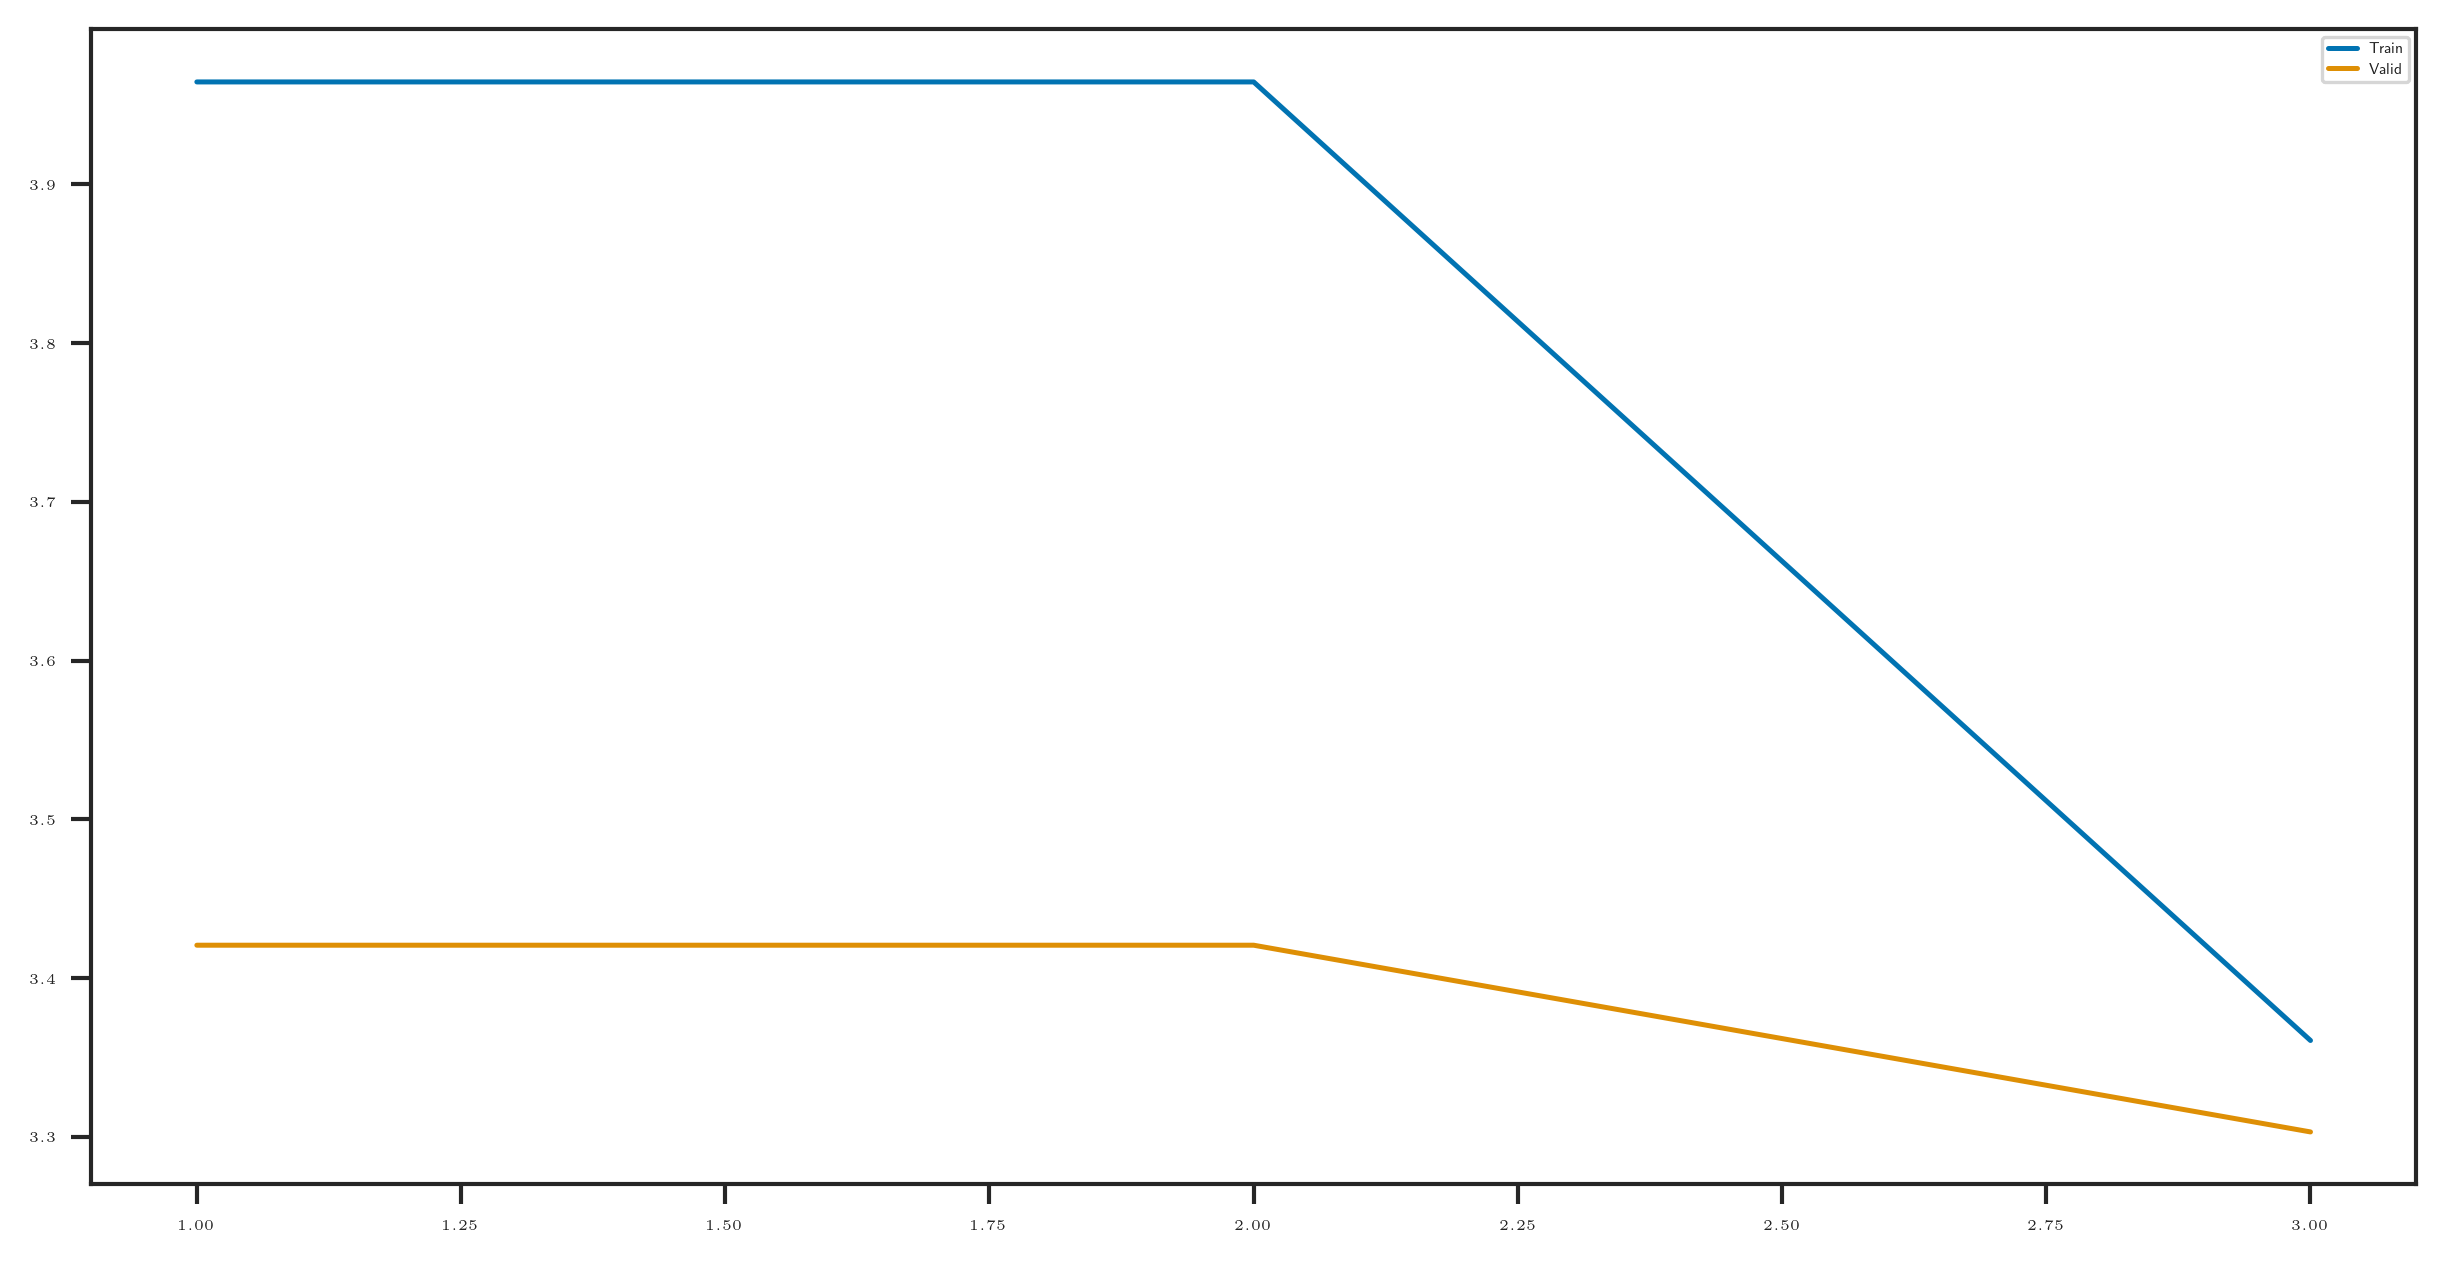

In [18]:
plt.figure(figsize=(10,5))

plt.plot(df['num_epochs'], df['mean_train_loss'], label = 'Train')
plt.plot(df['num_epochs'], df['mean_valid_loss'], label = 'Valid')

plt.legend()
plt.show()

In [15]:
xaxis = 'num_epochs' # 'num_episodes' 'num_epochs' 'num_actor_steps'

# rolling_window = None
# rolling_window = int(5)
# rolling_window = int(10)
# rolling_window = int(50)
# rolling_window = int(100)
# rolling_window = int(150)
# rolling_window = int(300)
# rolling_window = int(500) # paper training curve
rolling_window = int(1e3)
# rolling_window = int(5e3)
# rolling_window = int(10e3)

xlog = False # False True
ylog = True # False True

xaxis_label_style = 'sci' # paper training curve
yaxis_label_style = 'plain'

xlim = None
# xlim = [0, 2e5] # paper training curve
# xlim = [0, 1e5]
# xlim = [0, 1.5e5]
xlim = [0, 2.3e5]
ylim = None

# legend = False # 'auto' False
legend = 'auto'

# scaling_factor = 0.6 # paper training curve
# scaling_factor = 2.5
scaling_factor = 0.4
width_scaling_factor = 1
height_scaling_factor = 1

aesthetics = PlotAesthetics()
# aesthetics.set_icml_paper_plot_aesthetics() # paper training curve
aesthetics.set_icml_paper_plot_aesthetics(font_scale=0.4, linewidth=0.4)

In [16]:
print(f'Original df:')
display(df[:15])
display(df)
display(df[-15:])

# # # OLD
# _new_df = copy.deepcopy(df)





# NEW NEW
# for each x val, repeat y val with some minimum resolution until next x val encountered to fill out 'missing' data
min_res = 10

# convert dict vals from idx -> val dict to val list
new_df_dict = copy.deepcopy(df).to_dict()
for key, val in new_df_dict.items():
    new_df_dict[key] = list(val.values())

# perform x-val interpolation
num_insertions = 0
for idx, val in enumerate(df[xaxis][:-1]):
    diff = df[xaxis].iloc[idx+1] - df[xaxis].iloc[idx]
    num_increments = int(diff / min_res)
    print(f'\norig idx {idx} val: {val} | idx+1 val: {df[xaxis].iloc[idx+1]} | diff: {diff} | num_increments: {num_increments}')
    if diff != min_res and num_increments != 0:
        for i in range(num_increments):
            print(f'i: {i} -> insert val {val+((i+1)*min_res)} at idx {idx+i+num_insertions+1}')
            new_df_dict[xaxis].insert(idx+i+num_insertions+1, val+((i+1)*min_res))
            for column in df.columns:
                if column != xaxis:
                    new_df_dict[column].insert(idx+i+num_insertions+1, df[column][idx])
    else:
        # no need to interpolate to next x val
        print('no interpolation needed')
    num_insertions += num_increments
interpolated_df = pd.DataFrame(new_df_dict)
print(f'\ninterpolated_df with interpolated x vals:')
display(interpolated_df[:15])
display(interpolated_df)
_new_df = copy.deepcopy(interpolated_df)







# NEW
# remove any duplicate x-values to prevent NaNs when using pd.rolling()
new_df = defaultdict(list)
for agent in agent_to_path.keys():
# for agent in ['Retrospective']:
    print(f'\nAgent: {agent}')
    # select agent's values
    _agent_df = interpolated_df.loc[interpolated_df['Agent'] == agent]
    print(f'Agent df indexed by agent:\n{_agent_df[:15]}')
    
    # average entries of any duplicate x-axis values
    agent_df = _agent_df.groupby(xaxis, as_index=False).mean()
#     agent_df = _agent_df.drop_duplicates(subset=[xaxis], keep='first')
    print(f'Agent df averaged over duplicate {xaxis} values:\n{agent_df[:15]}')
    
    # put agent labels back into agent dataframe
    agent_df['Agent'] = [agent for _ in range(len(agent_df))]
    print(f'Agent df with {agent} rows re-applied:\n{agent_df[:15]}')
    
#     sns.lineplot(data=agent_df, x='num_epochs', y='num_nodes')
#     plt.show()
    
    for key, col in agent_df.to_dict().items():
        print(key)
        vals = list(col.values())
        new_df[key].extend(vals)
_new_df = pd.DataFrame(new_df)
print('New df with deleted repeat values')
display(_new_df[:15])
display(_new_df)

Original df:


,mean_train_loss,mean_valid_loss,num_epochs
0,3.964586,3.420622,1
1,3.964586,3.420622,2
2,3.360586,3.302969,3


,mean_train_loss,mean_valid_loss,num_epochs
0,3.964586,3.420622,1
1,3.964586,3.420622,2
2,3.360586,3.302969,3


,mean_train_loss,mean_valid_loss,num_epochs
0,3.964586,3.420622,1
1,3.964586,3.420622,2
2,3.360586,3.302969,3



orig idx 0 val: 1 | idx+1 val: 2 | diff: 1 | num_increments: 0
no interpolation needed

orig idx 1 val: 2 | idx+1 val: 3 | diff: 1 | num_increments: 0
no interpolation needed

interpolated_df with interpolated x vals:


,mean_train_loss,mean_valid_loss,num_epochs
0,3.964586,3.420622,1
1,3.964586,3.420622,2
2,3.360586,3.302969,3


,mean_train_loss,mean_valid_loss,num_epochs
0,3.964586,3.420622,1
1,3.964586,3.420622,2
2,3.360586,3.302969,3



Agent: il_10


KeyError: 'Agent'

In [ ]:
# calc rolling averages
new_df = copy.deepcopy(_new_df)
if rolling_window is not None:
    for param in ['num_nodes', 'lp_iterations', 'R']:
#         new_df[param] = _new_df[param].rolling(rolling_window, center=False).mean()
#         new_df[param] = _new_df[param].rolling(rolling_window, center=False).mean().fillna(method='bfill').fillna(method='ffill')
        new_df[param] = _new_df[param].rolling(rolling_window, center=False).mean()
    print(f'\nNew DF after applying rolling average:')
    display(new_df[:15])
    display(new_df)
    display(new_df[-15:])

# xaxis = 'num_episodes' # TEMPORARY
    
if xaxis == 'num_episodes':
    xlabel = 'Episodes'
elif xaxis == 'num_epochs':
    xlabel = 'Learner Steps' # paper training curve
    xlabel = 'Epochs'
elif xaxis == 'num_actor_steps':
    xlabel = 'Actor Steps'
else:
    raise Exception(f'Have not yet implemented xlabel for xaxis {xaxis}')

In [ ]:
f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
g = sns.lineplot(data=new_df, x=xaxis, y='num_nodes', hue='Agent', linewidth=aesthetics.linewidth, legend=legend)
if xlim is not None:
    plt.xlim(left=xlim[0], right=xlim[1])
if ylim is not None:
    plt.ylim(bottom=ylim[0], top=ylim[1])
# plt.legend(loc='upper right')
# ax.legend(loc='lower left', bbox_to_anchor=(0, 1.02, 1, 0.2), ncol=2, prop={'size': 3})
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=3, prop={'size': 3})
g.set_xlabel(xlabel)
g.set_ylabel('Nodes')
plt.ticklabel_format(style=xaxis_label_style, axis='x', scilimits=(0,0))
plt.ticklabel_format(style=yaxis_label_style, axis='y', scilimits=(0,0))
ax.tick_params(axis='both', which='major', pad=2)
ax.xaxis.labelpad = 2
ax.yaxis.labelpad = 2
sns.despine(ax=ax) # remove top and right spines
if xlog:
    g.set(xscale='log')
if ylog:
    g.set(yscale='log')
plt.gcf().patch.set_alpha(0.0)
plt.show()



f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
g = sns.lineplot(data=new_df, x=xaxis, y='lp_iterations', hue='Agent', linewidth=aesthetics.linewidth, legend=legend)
if xlim is not None:
    plt.xlim(left=xlim[0], right=xlim[1])
if ylim is not None:
    plt.ylim(bottom=ylim[0], top=ylim[1])
g.set_xlabel(xlabel)
g.set_ylabel('LP Iterations')
plt.ticklabel_format(style=xaxis_label_style, axis='x', scilimits=(0,0))
plt.ticklabel_format(style=yaxis_label_style, axis='y', scilimits=(0,0))
ax.tick_params(axis='both', which='major', pad=2)
ax.xaxis.labelpad = 2
ax.yaxis.labelpad = 2
sns.despine(ax=ax) # remove top and right spines
if xlog:
    g.set(xscale='log')
if ylog:
    g.set(yscale='log')
plt.gcf().patch.set_alpha(0.0)
plt.show()



f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
g = sns.lineplot(data=new_df, x=xaxis, y='R', hue='Agent', linewidth=aesthetics.linewidth, legend=legend)
plt.ticklabel_format(style=xaxis_label_style, axis='x', scilimits=(0,0))
plt.ticklabel_format(style=yaxis_label_style, axis='y', scilimits=(0,0))
ax.tick_params(axis='both', which='major', pad=2)
ax.xaxis.labelpad = 2
ax.yaxis.labelpad = 2
sns.despine(ax=ax) # remove top and right spines
if xlim is not None:
    plt.xlim(left=xlim[0], right=xlim[1])
if ylim is not None:
    plt.ylim(bottom=ylim[0], top=ylim[1])
g.set_xlabel(xlabel)
g.set_ylabel('Return')
plt.show()

### Note to self

Sometimes when plot e.g. num_nodes vs. learner_steps, may get a large spike with the sub-trees approach. This occurs because the actor encounters a particularly long episode (e.g. usually actor has num_nodes=50, but then encounters episode with num_nodes=10,000, num_steps=5,000). At end of epsiode, sub-trees are constructed and added to buffer, and learner will then perform num_steps/num_steps_per_update learner steps. So in this example, if num_steps_per_update=5, the learner will perform 1,000 learner steps *before gathering any more experiences*, so num nodes will be fixed at this high number for multiple learner steps/epochs.